<a href="https://colab.research.google.com/github/RylieWeaver/Hyperparameter-Optimization/blob/main/Proof_of_Concept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameter Optimization for Candle/Improve (Deap)

**Project Goal:** View the hyperparameter space while performing hyperparameter optimization (HPO) by plotting the hyperparameters and colorizing with the loss function while running deap/other HPO algorithms.

**Current Progress:** Proof of concept and learning deap.

In [ ]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 3.3 MB/s eta 0:00:00


## Proof of Concept:

*   **Step 1:** Can a general shape be visualized this way with deap?
*   **Step 2:** Can multiple local minima and the general shape of more odd functions be visualized?
*   **Step 3:** Can the shape be visualized with discrete variables, and can the discrete variables be kept discrete during evolution (as needed for certain hyperparameters)?





### Step 1

Make a deap plot and a contour plot of the sphere function. Compare, could we visualize the contour plot from the deap plot?

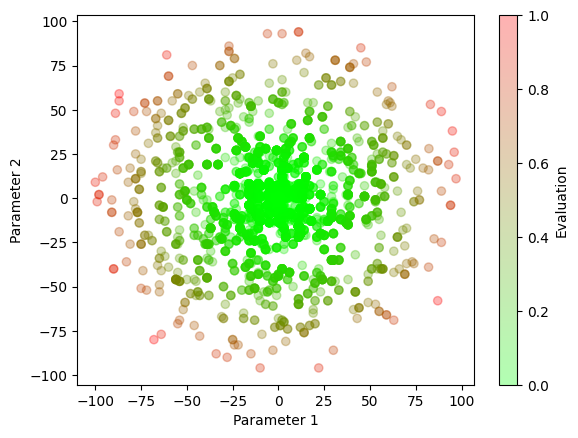

Best individual is: [2.0811474666903142e-05, 0]
with fitness: (4.3311747781115126e-10,)


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from deap import algorithms, base, creator, tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, -100, 100)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    x = individual[0]
    y = individual[1]
    return (x**2 + y**2),

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def main():
    import numpy

    pop = toolbox.population(n=1000)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    param1_data = []
    param2_data = []
    eval_data = []

    for gen in range(100):
        offspring = algorithms.varAnd(pop, toolbox, cxpb=0.2, mutpb=0.1)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        pop = toolbox.select(offspring, k=len(pop))
        hof.update(pop)

        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(pop), **record)
        # print(logbook.stream)

        # Append parameter values and evaluation values for scatter plot
        param1_data.extend([ind[0] for ind in pop])
        param2_data.extend([ind[1] for ind in pop])
        eval_data.extend([ind.fitness.values[0] for ind in pop])

    # Normalize evaluation values to the range [0, 1]
    normalized_eval = (np.array(eval_data) - min(eval_data)) / (max(eval_data) - min(eval_data))

    # Define the colormap
    cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#00FF00', '#FF0000'])

    # Scatter plot with custom colors based on evaluation values
    plt.scatter(param1_data, param2_data, c=normalized_eval, cmap=cmap, alpha=0.3)
    plt.colorbar(label='Evaluation')
    plt.xlabel("Parameter 1")
    plt.ylabel("Parameter 2")
    plt.show()

    return pop, logbook, hof

if __name__ == "__main__":
    pop, log, hof = main()
    print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))

    gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")


<ipython-input-3-f2f205ee6400>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')


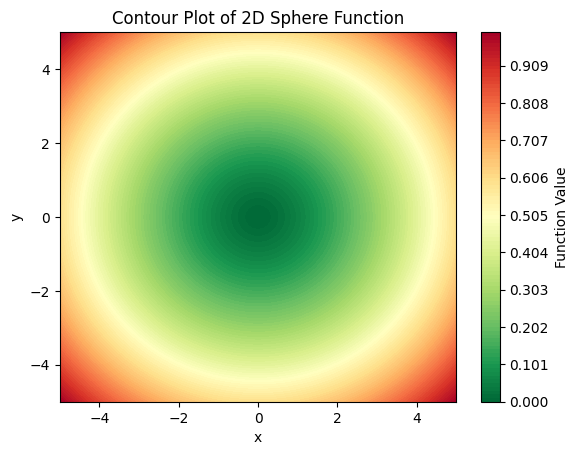

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sphere(x, y):
    return x**2 + y**2

# Create a grid of points
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# Evaluate the function at each point in the grid
Z = sphere(X, Y)
Z_norm = (Z-np.min(Z))/(np.max(Z)-np.min(Z))

# Create a contour plot with red to green colormap
levels = np.linspace(np.min(Z_norm), np.max(Z_norm), 100)
cmap = plt.cm.get_cmap('RdYlGn_r')
plt.contourf(X, Y, Z_norm**0.75, levels=levels, cmap=cmap)

# Add a colorbar for reference
cbar = plt.colorbar()
cbar.set_label('Function Value')

# Add labels and title to the plot
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour Plot of 2D Sphere Function')

# Display the plot
plt.show()

### Step 2.1

Can multiple local minima be visualized (rastigin function)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from deap import algorithms, base, creator, tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.uniform, -15, 15)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    x1 = individual[0]
    x2 = individual[1]
    eval = 20 + ((x1/np.pi)**2 - 10 * np.cos(2 * (x1/np.pi))) + ((x2/np.pi)**2 - 10 * np.cos(2 * (x2/np.pi)))
    return eval,

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def main():

    pop = toolbox.population(n=1000)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    param1_data = []
    param2_data = []
    eval_data = []

    for gen in range(100):
        offspring = algorithms.varAnd(pop, toolbox, cxpb=0.2, mutpb=0.1)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        pop = toolbox.select(offspring, k=len(pop))
        hof.update(pop)

        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(pop), **record)
        # print(logbook.stream)

        # Append parameter values and evaluation values for scatter plot
        param1_data.extend([ind[0] for ind in pop])
        param2_data.extend([ind[1] for ind in pop])
        eval_data.extend([ind.fitness.values[0] for ind in pop])

    return pop, logbook, hof, param1_data, param2_data, eval_data


if __name__ == "__main__":
    pop, log, hof, param1_data, param2_data, eval_data = main()
    print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))

    gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")

/usr/local/lib/python3.10/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Best individual is: [-0.0012206615269272489, 0.0011923983320329293]
with fitness: (6.195627495486633e-06,)


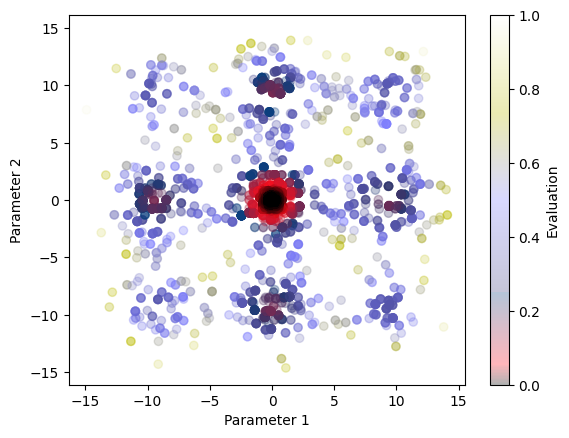

In [ ]:
# Normalize evaluation values to the range [0, 1]
normalized_eval = (np.array(eval_data) - min(eval_data)) / (max(eval_data) - min(eval_data))

# Define the colormap
# cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#00FF00', '#FF0000'])
cmap = 'gist_stern'

# Scatter plot with custom colors based on evaluation values
plt.scatter(param1_data, param2_data, c=normalized_eval, cmap=cmap, alpha=0.3)
plt.colorbar(label='Evaluation')
plt.xlabel("Parameter 1")
plt.ylabel("Parameter 2")
plt.show()

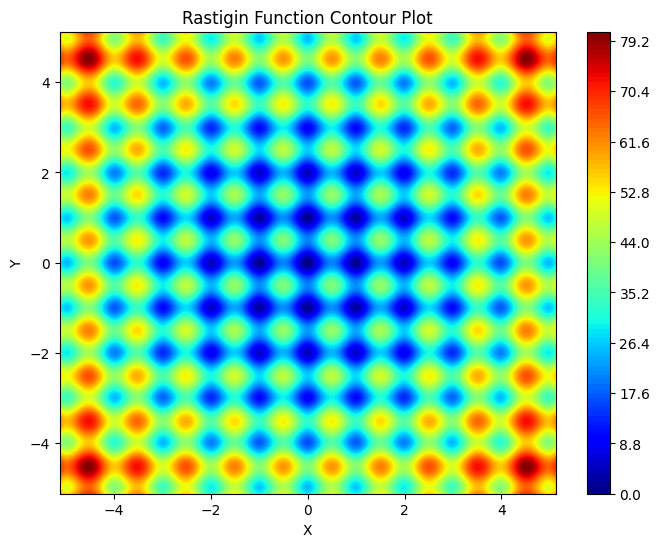

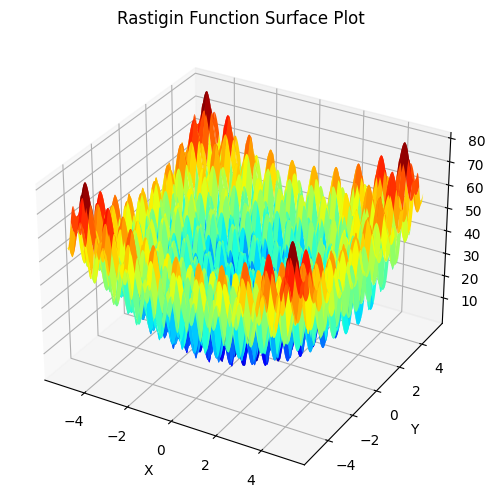

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def rastigin(x):
    A = 10
    n = len(x)
    return A * n + sum(xi**2 - A * np.cos(2 * np.pi * xi) for xi in x)

# Define the range for each dimension
x_range = np.linspace(-5.12, 5.12, 500)
y_range = np.linspace(-5.12, 5.12, 500)

# Create a meshgrid for the x and y ranges
X, Y = np.meshgrid(x_range, y_range)

# Calculate the corresponding Z values using the Rastigin function
Z = rastigin([X, Y])

# Plot the contour plot
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=100, cmap='jet')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Rastigin Function Contour Plot')
plt.show()

# Plot the 3D surface plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='jet')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Rastigin Function Surface Plot')
plt.show()

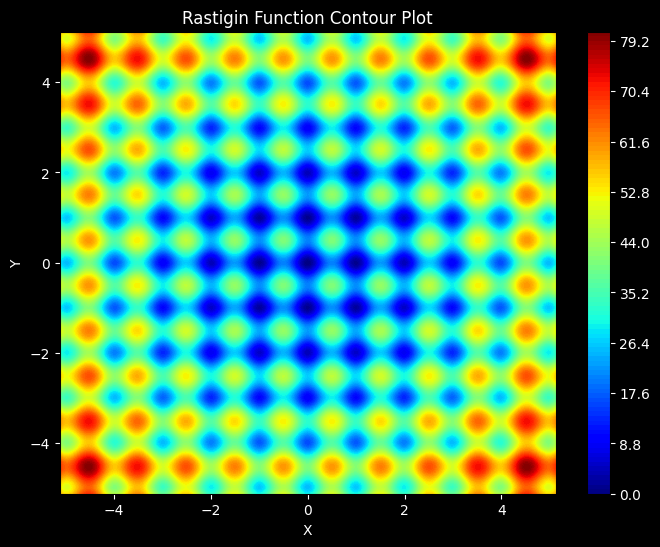

### Step 2.2

Can a more odd function be visualized (beale function)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from deap import algorithms, base, creator, tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.uniform, -15, 15)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    x1 = individual[0]
    x2 = individual[1]
    term1 = (1.5 - x1 + x1 * x2) ** 2
    term2 = (2.25 - x1 + x1 * x2 ** 2) ** 2
    term3 = (2.625 - x1 + x1 * x2 ** 3) ** 2
    eval = term1 + term2 + term3
    return eval,

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def main():

    pop = toolbox.population(n=1000)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    param1_data = []
    param2_data = []
    eval_data = []

    for gen in range(100):
        offspring = algorithms.varAnd(pop, toolbox, cxpb=0.2, mutpb=0.1)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        pop = toolbox.select(offspring, k=len(pop))
        hof.update(pop)

        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(pop), **record)
        # print(logbook.stream)

        # Append parameter values and evaluation values for scatter plot
        param1_data.extend([ind[0] for ind in pop])
        param2_data.extend([ind[1] for ind in pop])
        eval_data.extend([ind.fitness.values[0] for ind in pop])

    return pop, logbook, hof, param1_data, param2_data, eval_data


if __name__ == "__main__":
    pop, log, hof, param1_data, param2_data, eval_data = main()
    print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))

    gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")

Best individual is: [2.951366647563104, 0.486596509805015]
with fitness: (0.00042579966591754754,)


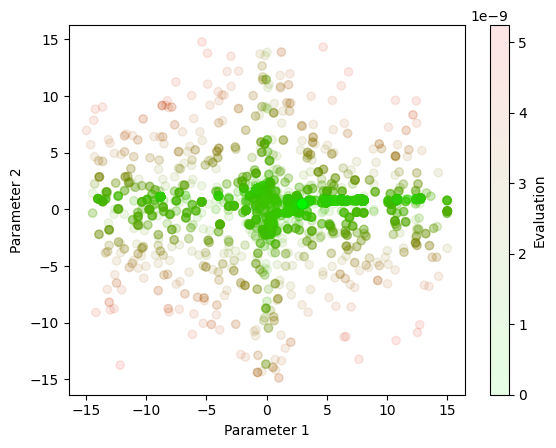

In [ ]:
# Normalize evaluation values to the range [0, 1]
normalized_eval = (np.array(eval_data) - min(eval_data))**0.08 / (max(eval_data) - min(eval_data))

# Define the colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#00FF00', '#FF0000'])

# Scatter plot with custom colors based on evaluation values
plt.scatter(param1_data, param2_data, c=normalized_eval, cmap=cmap, alpha=0.1)
plt.colorbar(label='Evaluation')
plt.xlabel("Parameter 1")
plt.ylabel("Parameter 2")
plt.show()

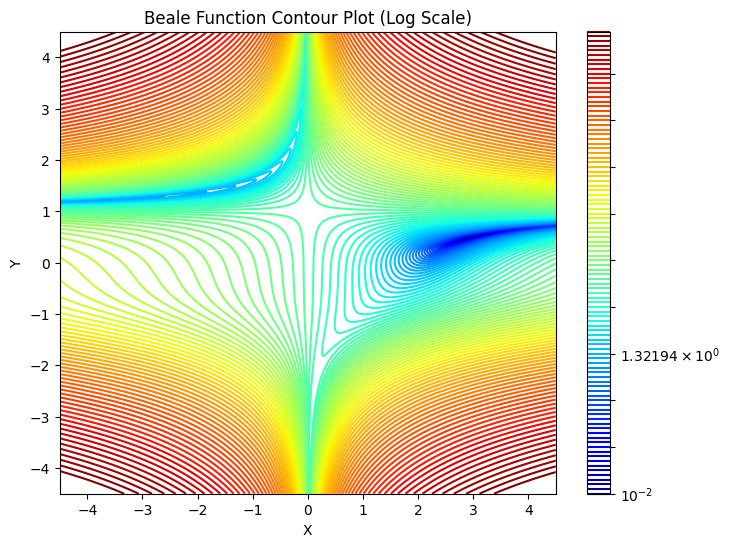

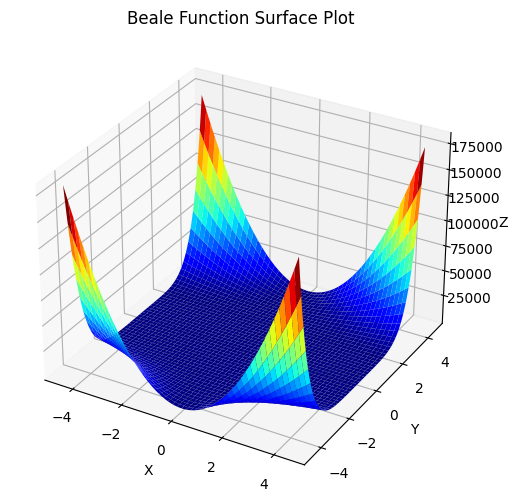

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def beale(x, y):
    term1 = (1.5 - x + x * y) ** 2
    term2 = (2.25 - x + x * y ** 2) ** 2
    term3 = (2.625 - x + x * y ** 3) ** 2
    return term1 + term2 + term3

# Define the range for each dimension
x_range = np.linspace(-4.5, 4.5, 500)
y_range = np.linspace(-4.5, 4.5, 500)

# Create a meshgrid for the x and y ranges
X, Y = np.meshgrid(x_range, y_range)

# Calculate the corresponding Z values using the Beale function
Z = beale(X, Y)

# Plot the contour plot with log scale
plt.figure(figsize=(8, 6))
plt.contour(X, Y, Z, levels=np.logspace(-2, 5, 100), norm=colors.LogNorm(), cmap='jet')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Beale Function Contour Plot (Log Scale)')
plt.show()

# Plot the 3D surface plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='jet')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Beale Function Surface Plot')
plt.show()

### Step 3

Make discrete variables and keep them discrete during mating and mutation. Does the visualization still work (sphere function).

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from deap import algorithms, base, creator, tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_cont", random.uniform, -10, 10)
toolbox.register("attr_disc", random.randint, 0, 10)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_cont, n=1)
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_cont, toolbox.attr_disc))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def eval(individual):
    x1 = individual[0]
    x2 = individual[1]
    eval = x1**2 + (x2-5)**2
    return eval,

toolbox.register("evaluate", eval)
toolbox.register("mate", tools.cxTwoPoint)

def mutate_continuous(value, mu, sigma, indpb_cont):
    if random.random() < indpb_cont:
        mutated_value, = tools.mutGaussian([value], mu, sigma, indpb_cont)
        return mutated_value[0]  # Unpack the list to return a single value
    return value

def mutate_integer_one_step(value, low, high, indpb_disc):
    if random.random() < indpb_disc:
        move = random.choice([-1, 0, 1])
        new_value = value + move
        # Ensure the new value stays within the range [low, high]
        value = max(low, min(high, new_value))
    return value

def custom_mutate(individual, mu, sigma, low, high, indpb_cont, indpb_int):
    individual[0] = mutate_continuous(individual[0], mu, sigma, indpb_cont)
    individual[1] = mutate_integer_one_step(individual[1], low, high, indpb_int)
    return individual,

toolbox.register("mutate", custom_mutate, mu=0, sigma=1, low=0, high=10, indpb_cont=0.2, indpb_int=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def main():

    pop = toolbox.population(n=1000)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    param1_data = []
    param2_data = []
    eval_data = []

    for gen in range(100):

        fits = toolbox.map(toolbox.evaluate, pop)
        for fit, ind in zip(fits, pop):
            ind.fitness.values = fit

        hof.update(pop)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(pop), **record)
        # print(logbook.stream)

        # Append parameter values and evaluation values for scatter plot
        param1_data.extend([ind[0] for ind in pop])
        param2_data.extend([ind[1] for ind in pop])
        eval_data.extend([ind.fitness.values[0] for ind in pop])

        offspring = algorithms.varAnd(pop, toolbox, cxpb=0.1, mutpb=0.3)

        pop = toolbox.select(offspring, k=len(pop))

    fits = toolbox.map(toolbox.evaluate, pop)
    for fit, ind in zip(fits, pop):
        ind.fitness.values = fit

    hof.update(pop)
    record = stats.compile(pop)
    logbook.record(gen=gen, evals=len(pop), **record)
    # print(logbook.stream)

    # Append parameter values and evaluation values for scatter plot
    param1_data.extend([ind[0] for ind in pop])
    param2_data.extend([ind[1] for ind in pop])
    eval_data.extend([ind.fitness.values[0] for ind in pop])

    return pop, logbook, hof, param1_data, param2_data, eval_data


if __name__ == "__main__":
    pop, log, hof, param1_data, param2_data, eval_data = main()
    print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))

    gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")

Best individual is: [0.033909130862442446, 5]
with fitness: (0.0011498291558462467,)


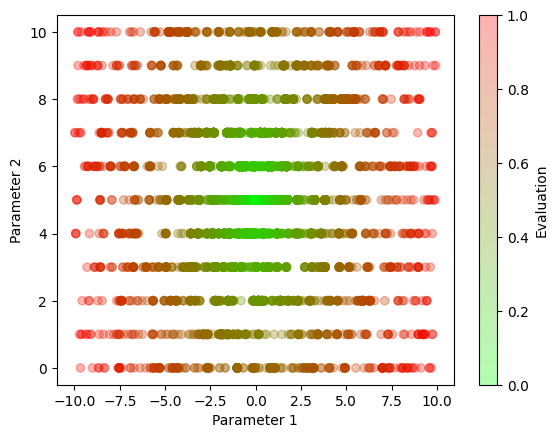

In [ ]:
# Normalize evaluation values to the range [0, 1]
normalized_eval = (np.array(eval_data) - min(eval_data)) / (max(eval_data) - min(eval_data))

# Define the colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#00FF00', '#FF0000'])

# Scatter plot with custom colors based on evaluation values
plt.scatter(param1_data, param2_data, c=normalized_eval**0.33, cmap=cmap, alpha=0.3)
plt.colorbar(label='Evaluation')
plt.xlabel("Parameter 1")
plt.ylabel("Parameter 2")
plt.show()

Visualize max/avg/min error plots just to see

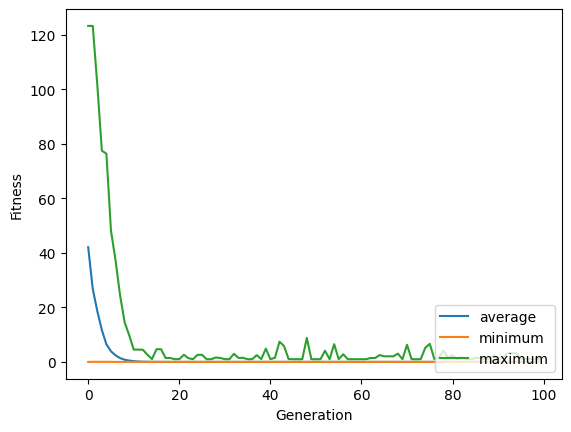

In [ ]:
# Plotting Min, Max, Avg... I'd chalk the jumps up to randomness
gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
# plt.ylim([0, 0.05])  # Specify y-axis range here
plt.legend(loc="lower right")

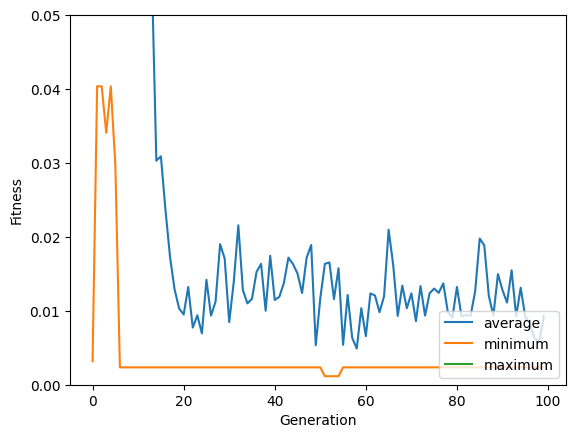

In [ ]:
# Plotting Min, Max, Avg... I'd chalk the jumps up to randomness
gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.ylim([0, 0.05])  # Specify y-axis range here
plt.legend(loc="lower right")